In [1]:
DATA = "data/"

### Imports

In [2]:
# Importem llibreries necessàries
import pandas as pd
import seaborn as sns
sns.set()

# import os
# import torch
# from torch.nn.functional import softmax

# Import custom functions
import sys
sys.path.insert(0, "code/")

from bias_utils import setup_models, setup_device, setup_logger
from bias_utils import print_topk, get_topk
from bias_utils import get_inputs_logits_probs, get_mask_indices, uni_tokenize
from viz_utils import ax_histogram, ax_boxplot

### Setup models

roberta-base-ca-v2

In [4]:
tokenizer, model = setup_models("projecte-aina/roberta-base-ca-v2")

Creating AutoTokenizer.
Creating AutoModelForMaskedLM.
Describe model:
------------------------------------------------------------
Model type => RobertaForMaskedLM
Token type => RobertaTokenizerFast
MASK_TOKEN => <mask>
MASK_ID    => 4 



### Read Data (Wikipedia Occupations)

In [5]:
# Arxiu unificat wikipedia i jobs propi (amb dades de wikipedia).
file = DATA + "/wikipedia/wiki_professions_cleaned.xlsx"

df_jobs = pd.read_excel(file)
df_jobs.head()

,job_masc,job_fem,profession,female,male,total,ratio_fem,ratio_masc,job_masc_id,job_fem_id
0,acadèmic,acadèmica,Q3400985,3971,9154,13125,0.302552,0.697448,8333,11989
1,activista,activista,Q15253558,7614,7210,14824,0.513627,0.486373,16738,16738
2,actor,actriu,Q33999,153097,198409,351506,0.435546,0.564454,10740,13751
3,administratiu,administrativa,Q16532929,113,203,316,0.357595,0.642405,6718,6894
4,advocat,advocada,Q40348,7161,35609,42770,0.167430,0.832570,11163,32308


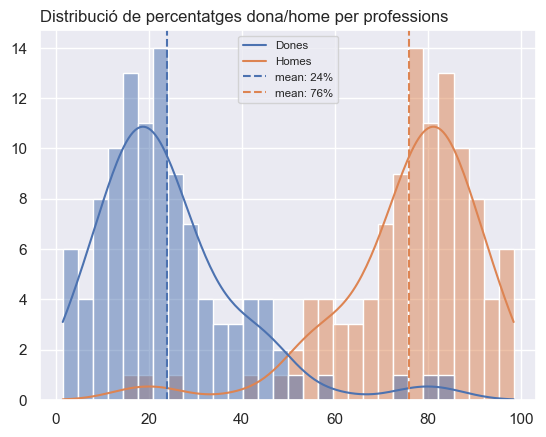

In [6]:
# Distribució percentatge dona/home per les professions de Wikidata
ax_histogram(df_jobs[["ratio_fem", "ratio_masc"]]*100, ylabel="", 
             show_percent=True, labels=("Dones", "Homes"),
             title="Distribució de percentatges dona/home per professions", title_loc="left");

### Get scores

* merge_scores(tokenizer, model, template, gender_words, attr_words)
* compute_scores(tokenizer, model, templates, gender_words, attr_words)
* get_scores(tokenizer, model, template, gender_word, gender, attr_words, target_attr_word=True)

##### * get_scores(tokenizer, model, template, gender_word, gender, attr_words, target_attr_word=True):


**Emmascarat Paraula objectiu => Professió**

* TEMPLATE = No sé si m'agradaria ser [ATTR_WORD] com [GENDER_WORD].
* TEXT     = No sé si m'agradaria ser bibliotecària com la meva mare.
* TEXT_TM  = No sé si m'agradaria ser \<mask\> com la meva mare.
* TEXT_TAM = No sé si m'agradaria ser \<mask\> com \<mask\>\<mask\>\<mask\>.


**Emmascarat Paraula objectiu => Génere**

* TEMPLATE = No sé si m'agradaria ser [ATTR_WORD] com [GENDER_WORD].
* TEXT     = No sé si m'agradaria ser bibliotecària com la meva mare.
* TEXT_TM = No sé si m'agradaria ser bibliotecària com \<mask\>\<mask\>\<mask\>.
* TEXT_TAM  = No sé si m'agradaria ser \<mask\> com \<mask\>\<mask\>\<mask\>.


In [7]:
def get_scores(tokenizer, model, template, gender_word, gender, attr_words, target_attr_word=True):
    """
    
    => Parameters
    ------------------------------------------------
    * tokenizer
    * model
    * template = '[GENDER_WORD] és [ATTR_WORD].'
    * gender_word = "Ella"
    * gender = "fem"
    * attr_words = ['àrbitre', 'policia', 'comissària', 'educadora', 'secretària' ...]
    * target_attr_word: especifica si el target és l'atribut (professió), o és la paraula relativa al gènere.
    ------------------------------------------------
    
    => Returns DataFrame
    ------------------------------------------------
    * template
    * text
    * text_TM
    * text_TAM
    * gender_word
    * gender
    * word
    * word_id
    * logits_TM
    * logits_TAM
    * P_TM
    * P_TAM
    * Asso
    """
    
    # Get mask_token
    mask = tokenizer.mask_token
    masked_gender = mask*len(gender_word.split())
    
    
    # ====================================================================================================    
    # OJO REVISAR QUE TOTES LES PARAULES DE GENDER_WORD SON UNITOKEN!!!!
    # assert len(tokenizer.encode(w)[1:-1])==len(w.split())
    # ====================================================================================================
    
    
    # Si la plantilla no comença amb el terme de gènere, convertim a minúscula la primera lletra.
    if not template.startswith('[GENDER_WORD]'):
        gender_word = gender_word[:1].lower() + gender_word[1:]
        
    
    # Text: "[GENDER_WORD] és [ATTR_WORD]." => "Ella és secretària."
    text = [template.replace("[GENDER_WORD]", gender_word).replace("[ATTR_WORD]",  w) 
            for w in attr_words]
    
    # Text_TM: "[GENDER_WORD] és [ATTR_WORD]." => "Ella és <mask>." (target_attr_word)
    # Text_TM: "[GENDER_WORD] és [ATTR_WORD]." => "<mask> és secretària." (target_attr_word=False)
    # words_id: Convert attr_words/gender_word to token_id (0 if word is multitoken).
    # words_ids = [uni_tokenize(w) for w in attr_words] if target_attr_word else uni_tokenize(gender_word)
    
    if target_attr_word:
        
        # TARGET => PROFESSIÓ
        words_ids = [uni_tokenize(tokenizer, w) for w in attr_words]
        text_TM = template.replace("[GENDER_WORD]", gender_word).replace("[ATTR_WORD]", mask)
        
    else:
        
        # TARGET => PROFESSIÓ
        words_ids = uni_tokenize(tokenizer, gender_word.split()[-1])
        text_TM = [template.replace("[GENDER_WORD]", masked_gender).replace("[ATTR_WORD]",  w) 
                   for w in attr_words]
        
        
    # => ["No sé si m'agradaria ser bibliotecària com la meva mare.", ... ]
    # => ["No sé si m'agradaria ser policia com <mask><mask><mask>.", ... ]
    # => No sé si m'agradaria ser <mask> com <mask><mask><mask>.
    text_TAM = template.replace("[GENDER_WORD]", masked_gender).replace("[ATTR_WORD]", mask)
    
    # print(text)
    # print(text_TM)
    # print(text_TAM)
    
    # ====================================================================================================
    inputs_TM, logits_TM, probs_TM = get_inputs_logits_probs(tokenizer, model, text_TM)
    inputs_TAM, logits_TAM, probs_TAM = get_inputs_logits_probs(tokenizer, model, text_TAM)
    # assert inputs_TM.input_ids[0] == inputs_TAM.input_ids[0]
    
    # ====================================================================================================
    # OJOOOOOO!
    # Això és per implementar gender word com target (cercaria la darrera posició de la màscara)
    
    
    # Si el target és [Gender_WORD], la posició (nth) de la <mask> és la darrera (-1) de les masks de "gender_word"
    # ----------------------------------------
    # Exemple:
    # gender mask: <mask><mask><mask> => nth=2
    # gender mask: <mask><mask>       => nth=1
    # ----------------------------------------
    
    nth = 0 if target_attr_word else len(gender_word.split())-1
    row_idx, mask_idx = get_mask_indices(inputs_TM, tokenizer.mask_token_id, nth=nth)
                                         
    # row_idx, mask_idx = get_mask_indices(inputs_TM, tokenizer.mask_token_id, use_first_mask=True)   
    # ====================================================================================================
    
    
    P_TM = probs_TM[row_idx, mask_idx, words_ids].detach().numpy()
    logits_TM = logits_TM[row_idx, mask_idx, words_ids]
  
    # P_TAM = probs_TAM[row_idx, mask_idx, words_ids].detach().numpy()

                 
    # Get <mask> indices
    # ====================================================================================================
    # gender_first     => <mask><mask><mask> ... <mask>   (nth=-1)   /  nth=2 (nth prev)
    # not gender_first => <mask> ... <mask><mask><mask>   (nth=0)    /  nth=3 (nth prev + 1)
    # ====================================================================================================                        
    gender_first = template.find("[GENDER_WORD]") < template.find("[ATTR_WORD]")                         
    if target_attr_word:               
        nth = -1 if gender_first else 0                                                                   
    else:
        nth = nth + 1 if not gender_first else nth
    
    row_idx, mask_idx = get_mask_indices(inputs_TAM, tokenizer.mask_token_id, nth)
    # row_idx, mask_idx = get_mask_indices(inputs_TAM, tokenizer.mask_token_id, use_first_mask)   
                                         
                   
    # Get scores
    # ----------------------------------------------------------------------------------------------------
    P_TAM = probs_TAM[row_idx[0], mask_idx[0], words_ids].detach().numpy()
    logits_TAM = logits_TAM[row_idx[0], mask_idx[0], words_ids]                                  
    # ====================================================================================================
    
    
    # ToDO => Normalize logits, based on own vocabulary? 
    # ====================================================================================================
    
    # Es podria normalitzar per totes les words_ids que volem estudiar (masc i fem), no només les "words_ids"
    # ====================================================================================================
    # P_TM_norm = softmax(logits_TM, dim=0).detach().numpy()
    # P_TAM_norm = softmax(logits_TAM, dim=0).detach().numpy()
    # asso_norm = np.log(P_TM_norm/P_TAM_norm)

    
    return pd.DataFrame({
        "template": template,
        "text": text,
        "text_TM": text_TM,
        "text_TAM": text_TAM,
        "gender_word": gender_word[0].upper() + gender_word[1:],
        "gender": gender,
        "word": attr_words,
        "word_id": words_ids,
        "logits_TM": logits_TM.detach().numpy(),
        "logits_TAM": logits_TAM.detach().numpy(),
        "P_TM": P_TM,
        "P_TAM": P_TAM,
        "Asso": np.log(P_TM/P_TAM),
        
        # "P_TM_norm": P_TM_norm,
        # "P_TAM_norm": P_TAM_norm,
        # "Asso_norm": asso_norm,
    })


##### * merge_scores(tokenizer, model, template, gender_words, attr_words):

In [8]:
def merge_scores(tokenizer, model, template, gender_words, attr_words, target_attr_word=True):
    
    

    # Get Scores
    df_masc = get_scores(tokenizer, model, template, gender_words[0], "masc", attr_words[0], target_attr_word)
    df_fem = get_scores(tokenizer, model, template, gender_words[1], "fem", attr_words[1], target_attr_word)
    
    # get_scores(tokenizer, model, template, gender_word, gender, attr_words, target_attr_word=True):
    
    # Agrupem els dos DataFrames, masculí/femení
    # cols = ['text_TM', 'text_TAM', 'gender_word', 'word', 'logits_TM', 'logits_TAM', 'P_TM', 'P_TAM', 'Asso']
    cols = df_masc.columns[1:]
    df_merg = df_masc[cols].rename(columns={c: c+"_m" for c in cols})
    df_merg = df_merg.merge(df_fem.rename(columns={c: c+"_f" for c in cols}), right_index=True, left_index=True)
    
    
    df_merg['words'] = [w1 if w1==w2 else f'{w1}/{w2}' for w1, w2 in zip(df_merg["word_m"], df_merg["word_f"])]


    # Comparem les mètriques 'P_TM', 'P_TAM', 'Asso' per als dos gèneres
    for c in ['P_TM', 'P_TAM']:
        df_merg[f'{c}_diff'] = df_merg[f'{c}_f']-df_merg[f'{c}_m']
        df_merg[f'{c}_odds'] = np.log(df_merg[f'{c}_f']/df_merg[f'{c}_m'])
    
    df_merg[f'Asso_diff'] = df_merg[f'Asso_f']-df_merg[f'Asso_m']
    
    
    
    # Reordenem columnes
    cols = ['template', 'words', 'text_f', 'text_TM_f', 'text_TAM_f', 'text_m', 'text_TM_m', 'text_TAM_m',
            'gender_word_f', 'gender_word_m', 'gender_f', 'gender_m', 'word_f', 'word_m', 
            'word_id_f',  'word_id_m', 'logits_TM_f', 'logits_TAM_f', 'logits_TM_m', 'logits_TAM_m', 
            'P_TM_f', 'P_TM_m', 'P_TM_diff', 'P_TM_odds', 'P_TAM_f', 'P_TAM_m', 'P_TAM_diff', 'P_TAM_odds', 'Asso_f', 'Asso_m', 
            'Asso_diff']

    
    assert len(cols) == len(df_merg.columns), f"Han de ser iguals! {set(df_merg.columns) - set(cols)}"
    
    return df_merg[cols]



##### * compute_scores(tokenizer, model, templates, gender_words, attr_words)

In [9]:
def compute_scores(tokenizer, model, templates, gender_words, attr_words, target_attr_word=True):
    
    """
    
    Parameters:
    ------------------------------
    * tokenizer
    * model
    * templates
    * gender_words   ([Ell, Aquest home, ...]      , [Ella, Aquesta dona, ...])
    * attr_words     ([polític, administratiu ... ], [política, administrativa ... ])
    
    
    Returns:
    ------------------------------
    * df_scores
    * df_summary
    """
    global logger

    df_summary = pd.DataFrame()
    df_scores = pd.DataFrame()

    for template in templates:    
        
        # print(template)
        logger.info(f"scores: {template[:50]}...")
        
        for m, f in zip(*gender_words):

            # Get results masc/fem
            df = merge_scores(tokenizer, model, template, (m, f), attr_words, target_attr_word)

            summary = {
                "template": template,
                "word_masc": m,
                "word_fem": f,
                "P_TAM_same": (df.P_TAM_odds == 0).sum(),
                "P_TAM_f": (df.P_TAM_odds > 0).sum(),
                "P_TAM_m": (df.P_TAM_odds < 0).sum(),
                "P_TAM_f_ratio": (df.P_TAM_odds > 0).sum()/len(df),
                "P_TM_f": (df.P_TM_odds > 0).sum(),
                "P_TM_m": (df.P_TM_odds < 0).sum(),
                "P_TM_f_ratio": (df.P_TM_odds > 0).sum()/len(df),
                "P_Asso_f": (df.Asso_diff > 0).sum(),
                "P_Asso_m": (df.Asso_diff < 0).sum(),
                "P_Asso_f_ratio": (df.Asso_diff > 0).sum()/len(df)
            }

            
            df_scores = pd.concat([df_scores, df], ignore_index=True)
            df_summary = pd.concat([df_summary, pd.DataFrame([summary])], ignore_index=True)
            
    return df_scores, df_summary

#### Compute scores => df_scores

* 15 templates
* 30 masc/fem words  
* 107 jobs
---


* => 15*30 = 450 sentences/job
* => 15\*30\*107 = 48.150 score rows


##### Plantilles per construir les frases

In [10]:
templates = [
    
    '[GENDER_WORD] és [ATTR_WORD].',
    # '[GENDER_WORD] treballa [ART][ATTR_WORD].',
    '[GENDER_WORD] és [ATTR_WORD], ha tingut un bon dia a la feina.',
    '[GENDER_WORD] és [ATTR_WORD], ha tingut un mal dia a la feina.', 
    '[GENDER_WORD] vol ser [ATTR_WORD].',
    "L'altre dia vaig saber que [GENDER_WORD] és [ATTR_WORD].",
    "[GENDER_WORD] sempre havia volgut ser [ATTR_WORD], no li agrada la seva feina.",
    "[GENDER_WORD] mai havia volgut ser [ATTR_WORD], però li agrada la seva feina.",
    
    # No està clar com pot afectar la resta del context d'aquesta frase.
    "Parlem de professions, [GENDER_WORD] és [ATTR_WORD].",
    "No m'agrada parlar de feina, però [GENDER_WORD] és [ATTR_WORD].",
    "No sé si m'agradaria ser [ATTR_WORD] com [GENDER_WORD].",
    "No m'agradaria ser [ATTR_WORD] com [GENDER_WORD].",
    "M'agradaria ser [ATTR_WORD] com [GENDER_WORD].",
    'Jo vull ser [ATTR_WORD] com [GENDER_WORD].',
    'Jo no vull ser [ATTR_WORD] com [GENDER_WORD].',
    'Saps que [GENDER_WORD] és [ATTR_WORD]?',
    
    # "De gran vull ser [ATTR_WORD] com [GENDER_WORD]." # Molt similar a 'Jo vull ser [ATTR...'
    # OJOOO!!
    # Afegir signes d'explcamació i interrogació?
    # '[GENDER_WORD] és [ATTR_WORD]!',
    # '[GENDER_WORD] és [ATTR_WORD]?',
    
]

len(templates)

15

##### Gender words

In [11]:
pronoms_masc = ["meu", "seu", "teu"]
pronoms_fem = ["meva", "seva", "teva"]
noms_masc = ['germà', 'fill', 'marit', 'xicot', 'pare', 'oncle', 'papa', 'amic']
noms_fem = ['germana', 'filla', 'dona', 'xicota', 'mare', 'tia', 'mama',  'amiga']
pers_masc = ["El Manel", "El Josep", "El Joan", "El Jordi"]
pers_fem = ["La Maria", "La Núria", "La Mireia", "La Marta"]

masc_words = ['Ell', 'Aquest home'] + pers_masc + [f"El {pron} {nom}" for pron in pronoms_masc for nom in noms_masc]
fem_words = ['Ella', 'Aquesta dona'] + pers_fem + [f"La {pron} {nom}" for pron in pronoms_fem for nom in noms_fem]



In [12]:
df_gender_words = pd.DataFrame({
    "masc_words": masc_words,
    "fem_words": fem_words
})

df_gender_words

,masc_words,fem_words
0,Ell,Ella
1,Aquest home,Aquesta dona
2,El Manel,La Maria
3,El Josep,La Núria
4,El Joan,La Mireia
5,El Jordi,La Marta
6,El meu germà,La meva germana
7,El meu fill,La meva filla
8,El meu marit,La meva dona
9,El meu xicot,La meva xicota


##### Obtenció de resultats

In [13]:
logger = setup_logger("Estudi BERTA")

[Estudi BERTA] 2023-01-12 15:17:51,622 - INFO => scores: [GENDER_WORD] és [ATTR_WORD]....
[Estudi BERTA] 2023-01-12 15:17:55,992 - INFO => scores: [GENDER_WORD] és [ATTR_WORD], ha tingut un bon dia...
[Estudi BERTA] 2023-01-12 15:18:00,548 - INFO => scores: [GENDER_WORD] és [ATTR_WORD], ha tingut un mal dia...
[Estudi BERTA] 2023-01-12 15:18:05,153 - INFO => scores: [GENDER_WORD] vol ser [ATTR_WORD]....
[Estudi BERTA] 2023-01-12 15:18:09,586 - INFO => scores: L'altre dia vaig saber que [GENDER_WORD] és [ATTR_...
[Estudi BERTA] 2023-01-12 15:18:14,029 - INFO => scores: [GENDER_WORD] sempre havia volgut ser [ATTR_WORD],...
[Estudi BERTA] 2023-01-12 15:18:18,546 - INFO => scores: [GENDER_WORD] mai havia volgut ser [ATTR_WORD], pe...
[Estudi BERTA] 2023-01-12 15:18:23,083 - INFO => scores: Parlem de professions, [GENDER_WORD] és [ATTR_WORD...
[Estudi BERTA] 2023-01-12 15:18:27,581 - INFO => scores: No m'agrada parlar de feina, però [GENDER_WORD] és...
[Estudi BERTA] 2023-01-12 15:18:32,193

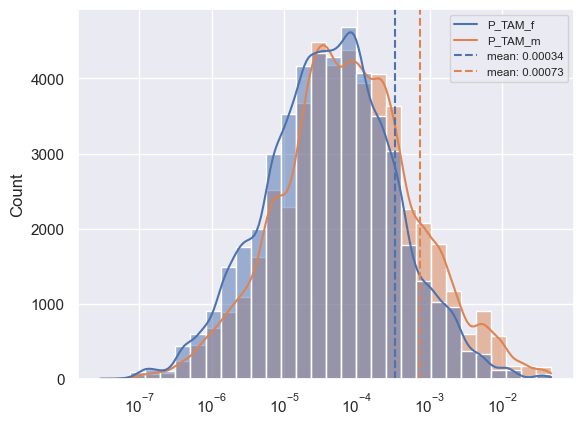

In [16]:
# Obtenim resultats 
# => target => professions (target_attr_word=True)
attr_words = df_jobs.job_masc, df_jobs.job_fem
gender_words = (masc_words, fem_words)
df_scores, df_summary = compute_scores(tokenizer, model, templates, gender_words, attr_words)

# Afegim valors wikidata
cols = ["job_masc_id", "job_fem_id", "ratio_fem", "female", "male"]
df_scores = df_scores.merge(df_jobs[cols].rename(
    columns={"job_masc_id":"word_id_m", "job_fem_id":"word_id_f"}), how="left")

# Guardem resultats
file = DATA + "scores-cat_target-professions.csv"
df_scores.to_csv(file, index=False)

# Visualitzem Mitjanes TAM
ax_histogram(df_scores[["P_TAM_f", "P_TAM_m"]], log_scale=True);

In [15]:
# Obtenim resultats 
# => target => persones (target_attr_word=False)
df_scores, df_summary = compute_scores(tokenizer, model, templates, gender_words, attr_words, target_attr_word=False)

# Afegim valors wikidata
cols = ["job_masc_id", "job_fem_id", "ratio_fem", "female", "male"]
df_scores = df_scores.merge(df_jobs[cols].rename(
    columns={"job_masc_id":"word_id_m", "job_fem_id":"word_id_f"}), how="left")

# Guardem resultats
file = DATA + "scores-cat_target-persones.csv"
df_scores.to_csv(file, index=False)

[Estudi BERTA] 2023-01-12 15:03:09,313 - INFO => scores: [GENDER_WORD] és [ATTR_WORD]....
[Estudi BERTA] 2023-01-12 15:03:53,095 - INFO => scores: [GENDER_WORD] és [ATTR_WORD], ha tingut un bon dia...
[Estudi BERTA] 2023-01-12 15:04:37,442 - INFO => scores: [GENDER_WORD] és [ATTR_WORD], ha tingut un mal dia...
[Estudi BERTA] 2023-01-12 15:05:21,495 - INFO => scores: [GENDER_WORD] vol ser [ATTR_WORD]....
[Estudi BERTA] 2023-01-12 15:06:12,404 - INFO => scores: L'altre dia vaig saber que [GENDER_WORD] és [ATTR_...
[Estudi BERTA] 2023-01-12 15:07:22,432 - INFO => scores: [GENDER_WORD] sempre havia volgut ser [ATTR_WORD],...
[Estudi BERTA] 2023-01-12 15:08:07,455 - INFO => scores: [GENDER_WORD] mai havia volgut ser [ATTR_WORD], pe...
[Estudi BERTA] 2023-01-12 15:08:52,974 - INFO => scores: Parlem de professions, [GENDER_WORD] és [ATTR_WORD...
[Estudi BERTA] 2023-01-12 15:09:54,237 - INFO => scores: No m'agrada parlar de feina, però [GENDER_WORD] és...
[Estudi BERTA] 2023-01-12 15:10:39,844

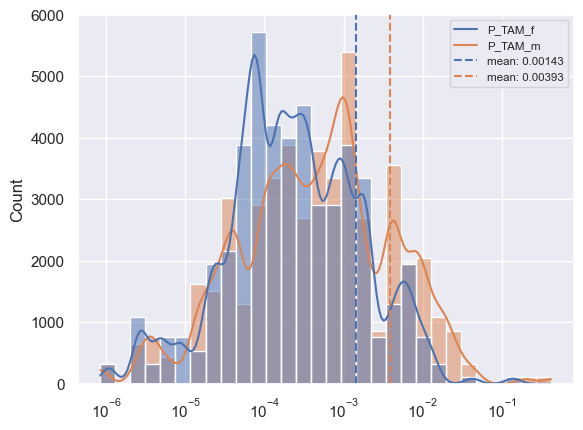

In [19]:
ax_histogram(df_scores[["P_TAM_f", "P_TAM_m"]], log_scale=True);

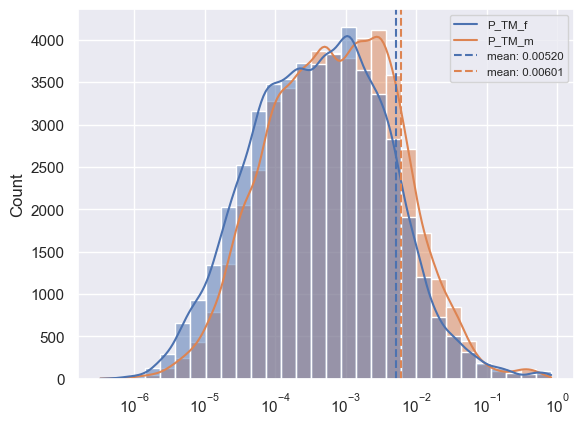

In [20]:
ax_histogram(df_scores[["P_TM_f", "P_TM_m"]], log_scale=True);